In [8]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델
import lightgbm as lgb

# 한글 폰트
import koreanize_matplotlib
koreanize_matplotlib.koreanize()

In [9]:
# 데이터 로드
train = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\train.csv')
test = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\test.csv')
submission = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\sample_submission.csv')

print(f"Train: {train.shape}, Test: {test.shape}")

Train: (630000, 13), Test: (270000, 12)


In [10]:
# 파생변수 생성 함수
def create_features(df):
    df = df.copy()
    
    # 범주형 인코딩
    sleep_map = {'poor': 1, 'average': 2, 'good': 3}
    facility_map = {'low': 1, 'medium': 2, 'high': 3}
    difficulty_map = {'easy': 1, 'moderate': 2, 'hard': 3}
    
    df['sleep_quality_num'] = df['sleep_quality'].map(sleep_map)
    df['facility_num'] = df['facility_rating'].map(facility_map)
    df['difficulty_num'] = df['exam_difficulty'].map(difficulty_map)
    
    # 조건부 상호작용 (핵심)
    df['study_quality_adj'] = df['study_hours'] * (df['sleep_quality_num'] / 3)
    df['study_facility_adj'] = df['study_hours'] * (df['facility_num'] / 3)
    df['attendance_sleep_synergy'] = (df['class_attendance'] / 100) * df['sleep_quality_num']
    
    # 효율성 지표
    df['waking_study_ratio'] = df['study_hours'] / (24 - df['sleep_hours'])
    df['study_sleep_ratio'] = df['study_hours'] / (df['sleep_hours'] + 0.1)
    df['total_investment'] = df['study_hours'] + df['sleep_hours']
    df['prep_vs_difficulty'] = df['study_hours'] / (df['difficulty_num'] + 0.5)
    
    # 비선형 변환
    df['study_sqrt'] = np.sqrt(df['study_hours'])
    df['study_log'] = np.log1p(df['study_hours'])
    df['study_sq'] = df['study_hours'] ** 2
    df['sleep_sq'] = df['sleep_hours'] ** 2
    
    # 최적 구간 거리
    df['study_optimal_dist'] = abs(df['study_hours'] - 5)
    df['sleep_deficit'] = np.maximum(0, 7 - df['sleep_hours'])
    df['sleep_excess'] = np.maximum(0, df['sleep_hours'] - 8)
    
    # 학생 프로파일
    df['hardworking_type'] = ((df['study_hours'] > 5) & (df['class_attendance'] > 85)).astype(int)
    df['cramming_type'] = ((df['study_hours'] > 6) & (df['sleep_hours'] < 6)).astype(int)
    
    # 출석 임계점
    df['attendance_low'] = (df['class_attendance'] < 70).astype(int)
    df['attendance_high'] = (df['class_attendance'] >= 90).astype(int)
    
    return df

In [11]:
# 파생변수 적용
train = create_features(train)
test = create_features(test)

print(f"파생변수 생성 후: {train.shape[1]}개 컬럼")

파생변수 생성 후: 34개 컬럼


In [12]:
# 범주형 변수 라벨 인코딩
cat_cols = ['gender', 'course', 'sleep_quality', 'study_method', 
            'facility_rating', 'exam_difficulty', 'internet_access']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print(f"라벨 인코딩 완료: {len(cat_cols)}개 컬럼")

라벨 인코딩 완료: 7개 컬럼


In [13]:
# 피처/타겟 분리
drop_cols = ['id', 'exam_score']
feature_cols = [col for col in train.columns if col not in drop_cols]

X = train[feature_cols]
y = train['exam_score']
X_test = test[feature_cols]

print(f"학습 피처: {X.shape[1]}개")

학습 피처: 32개


In [14]:
# LightGBM 모델 정의
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': 42
}

In [27]:
# LightGBM 학습 (Train/Valid Split)
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

model = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# 예측
oof_preds = model.predict(X_valid)
test_preds = model.predict(X_test)

print(f"\nLightGBM 학습 완료 (best_iteration: {model.best_iteration})")

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 8.85081
[200]	valid_0's rmse: 8.80239
[300]	valid_0's rmse: 8.78511
[400]	valid_0's rmse: 8.77211
[500]	valid_0's rmse: 8.7645
[600]	valid_0's rmse: 8.75827
[700]	valid_0's rmse: 8.75199
[800]	valid_0's rmse: 8.74516
[900]	valid_0's rmse: 8.7421
[1000]	valid_0's rmse: 8.73875
[1100]	valid_0's rmse: 8.7362
[1200]	valid_0's rmse: 8.73421
[1300]	valid_0's rmse: 8.73236
[1400]	valid_0's rmse: 8.73026
[1500]	valid_0's rmse: 8.72992
[1600]	valid_0's rmse: 8.72837
[1700]	valid_0's rmse: 8.72692
[1800]	valid_0's rmse: 8.7264
[1900]	valid_0's rmse: 8.72623
[2000]	valid_0's rmse: 8.72605
Did not meet early stopping. Best iteration is:
[1967]	valid_0's rmse: 8.72603

LightGBM 학습 완료 (best_iteration: 1967)


In [28]:
# LightGBM 성능 평가
lgb_rmse = np.sqrt(mean_squared_error(y_valid, oof_preds))
lgb_mae = mean_absolute_error(y_valid, oof_preds)
lgb_r2 = r2_score(y_valid, oof_preds)

print("LightGBM 결과")
print("="*40)
print(f"Valid RMSE: {lgb_rmse:.4f}")
print(f"Valid MAE:  {lgb_mae:.4f}")
print(f"Valid R2:   {lgb_r2:.4f}")

LightGBM 결과
Valid RMSE: 8.7260
Valid MAE:  6.9527
Valid R2:   0.7859


In [29]:
# Feature Importance 확인
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("Top 15 Features:")
print(importance_df.head(15).to_string(index=False))

Top 15 Features:
                 feature   importance
      waking_study_ratio 6.561772e+08
      study_facility_adj 1.008796e+08
        class_attendance 8.637428e+07
attendance_sleep_synergy 7.619252e+07
             study_hours 7.250492e+07
       study_quality_adj 5.431422e+07
            study_method 4.884659e+07
               study_log 3.246929e+07
        total_investment 2.641753e+07
          attendance_low 8.068112e+06
      study_optimal_dist 4.720499e+06
         facility_rating 3.534109e+06
            facility_num 3.421139e+06
             sleep_hours 3.293047e+06
           sleep_quality 2.940147e+06


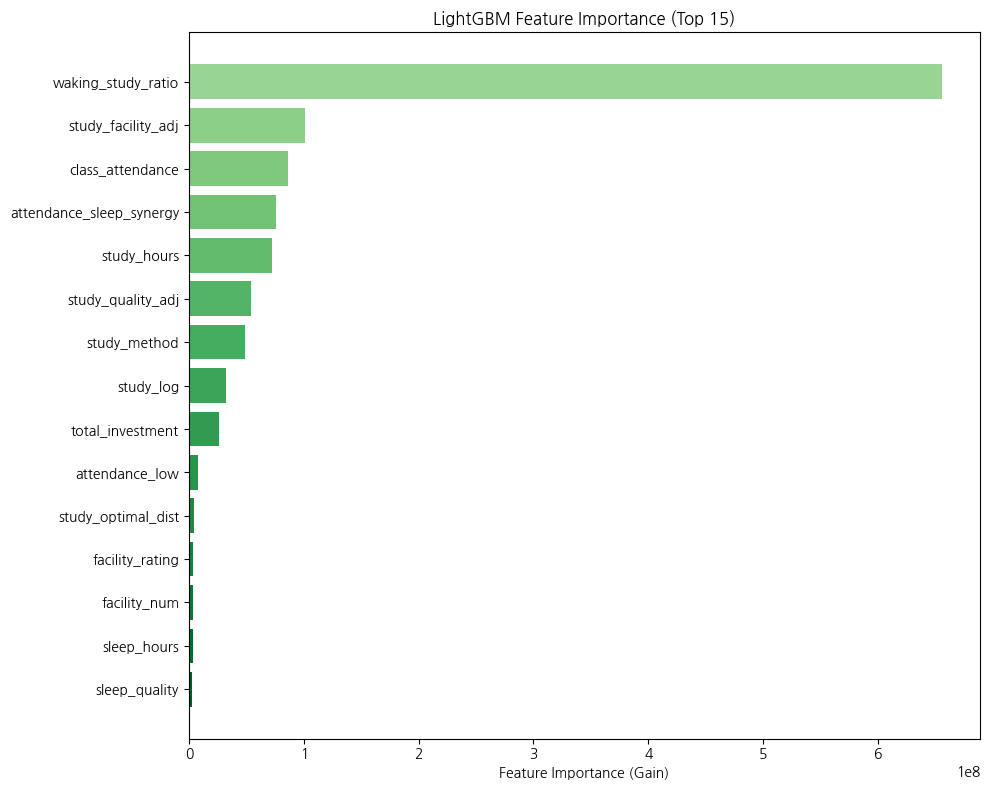

In [30]:
# Feature Importance 시각화 (LightGBM)
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
top_features_lgb = importance_df.head(top_n)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, top_n))[::-1]

ax.barh(range(top_n), top_features_lgb['importance'].values[::-1], color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_lgb['feature'].values[::-1])
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('LightGBM Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

In [31]:
# 제출 파일 생성
submission['exam_score'] = test_preds
submission.to_csv('submission.csv', index=False)

print("submission.csv 저장 완료")
submission.head()

submission.csv 저장 완료


,id,exam_score
0,630000,70.607471
1,630001,69.830264
2,630002,88.638836
3,630003,55.324879
4,630004,46.846161


---
## Part 2: 수치형 -> 범주형 Binning + CatBoost

**정현이 제안한 전략:**
1. 모든 수치형 피처를 Supervised Binning으로 범주화
2. CatBoost로 범주형 피처를 효과적으로 활용
3. t-test + Cohen's d 기반으로 의미있는 구간만 유지

In [20]:
# =========================================================
# 데이터 다시 로드 (깨끗한 상태에서 시작)
# =========================================================
train_cat = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\train.csv')
test_cat = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\test.csv')
submission_cat = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\sample_submission.csv')

# 파생변수 적용
train_cat = create_features(train_cat)
test_cat = create_features(test_cat)

print(f"Train: {train_cat.shape}, Test: {test_cat.shape}")

Train: (630000, 34), Test: (270000, 33)


In [21]:
# =========================================================
# 기본 설정
# =========================================================
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool

TARGET_COL = "exam_score"
ID_COL = "id"

# 저장 경로
SAVE_DIR = r"E:\2026_1\캐글 공모전\영현\sbmission_result"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------------------------------------------------
# 옵션 스위치 (조절 가능)
# ---------------------------------------------------------
DROP_NUMERIC = True   # True: 수치형을 bin 범주로 완전 대체 / False: 원본 수치형 유지 + bin 추가
INIT_BINS = 30        # 초기 분위수 bin 개수 (20~50 추천)
MAX_BINS  = 12        # 최종 bin 개수 상한
MIN_BIN_SIZE = 3000   # bin 최소 표본 수
ALPHA = 0.01          # 유의수준
MIN_EFFECT_D = 0.05   # 효과크기(cohen's d) 최소값

print("설정 완료")

설정 완료


In [22]:
# =========================================================
# Supervised Binning 함수 정의
# - 연속 타깃 기준 "의미 없는 인접 bin 병합"
# - 초기 분위수 bin -> 인접 bin끼리 평균차 Welch t-test
# - (p>alpha) 또는 (effect size < min_effect)면 병합
# =========================================================

def cohen_d(a, b):
    """효과 크기 (Cohen's d) 계산"""
    a = np.asarray(a); b = np.asarray(b)
    if len(a) < 2 or len(b) < 2:
        return 0.0
    va = np.var(a, ddof=1); vb = np.var(b, ddof=1)
    sp = np.sqrt(((len(a)-1)*va + (len(b)-1)*vb) / max(len(a)+len(b)-2, 1))
    if sp == 0:
        return 0.0
    return (np.mean(a) - np.mean(b)) / sp


def supervised_binning_continuous(
    x: pd.Series,
    y: np.ndarray,
    init_bins=30,
    max_bins=12,
    min_bin_size=3000,
    alpha=0.01,
    min_effect_d=0.05,
    verbose=False
):
    """수치형 피처를 타깃 기반으로 의미있는 구간으로 binning"""
    
    # 결측 제거
    df = pd.DataFrame({"x": x, "y": y}).dropna()
    if df["x"].nunique() < 10:
        # 값 다양성 부족 -> binning 의미 없음
        return [-np.inf, np.inf]

    # 초기 분위수 경계 생성(중복 제거)
    qs = np.linspace(0, 1, init_bins + 1)
    raw_edges = np.unique(np.quantile(df["x"].values, qs))

    # 경계가 너무 적으면 탈출
    if len(raw_edges) < 3:
        return [-np.inf, np.inf]

    # 양끝 무한대 포함
    edges = [-np.inf] + raw_edges[1:-1].tolist() + [np.inf]

    def make_groups(_edges):
        bins = pd.cut(df["x"], bins=_edges, include_lowest=True)
        groups = df.groupby(bins, observed=False)["y"].apply(np.asarray)
        return list(groups.values), list(groups.index)

    # 최소 bin size 만족시키기
    def enforce_min_size(_edges):
        changed = True
        while changed:
            changed = False
            ys, intervals = make_groups(_edges)
            if len(ys) <= 2:
                break
            sizes = np.array([len(v) for v in ys])
            if sizes.min() >= min_bin_size:
                break
            i = int(np.argmin(sizes))
            if i == 0:
                _edges.pop(1); changed = True
            elif i == len(ys) - 1:
                _edges.pop(-2); changed = True
            else:
                m = [np.mean(v) for v in ys]
                dl = abs(m[i] - m[i-1])
                dr = abs(m[i] - m[i+1])
                if dl <= dr:
                    _edges.pop(i)
                else:
                    _edges.pop(i+1)
                changed = True
        return _edges

    edges = enforce_min_size(edges)

    # 유의/효과 기준 병합 반복
    while True:
        ys, intervals = make_groups(edges)
        k = len(ys)
        if k <= 2:
            break

        # 인접 비교에서 "가장 덜 의미 있는 경계"를 찾아 제거
        pvals = []
        ds = []
        for i in range(k - 1):
            a, b = ys[i], ys[i+1]
            stat, p = ttest_ind(a, b, equal_var=False)
            d = abs(cohen_d(a, b))
            pvals.append(p); ds.append(d)

        pvals = np.array(pvals)
        ds = np.array(ds)

        if k > max_bins:
            idx = int(np.argmax(pvals))
        else:
            weak = np.where((pvals > alpha) | (ds < min_effect_d))[0]
            if len(weak) == 0:
                break
            idx = int(weak[np.argmax(pvals[weak])])

        remove_pos = idx + 1
        if 0 < remove_pos < len(edges) - 1:
            edges.pop(remove_pos)
        else:
            break

        edges = enforce_min_size(edges)

        if verbose:
            print(f"[merge] bins={len(edges)-1}, removed edge@{remove_pos}")

    return edges

print("Supervised Binning 함수 정의 완료")

Supervised Binning 함수 정의 완료


In [23]:
# =========================================================
# 수치형 → 범주형 Binning 적용
# =========================================================

# 피처 구분
drop_cols = [ID_COL, TARGET_COL]
feature_cols_cat = [c for c in train_cat.columns if c not in drop_cols]

# 원래 범주형 컬럼
cat_cols_original = ['gender', 'course', 'sleep_quality', 'study_method',
                     'facility_rating', 'exam_difficulty', 'internet_access']
cat_cols_original = [c for c in cat_cols_original if c in feature_cols_cat]

# 수치형 컬럼 (범주형 제외)
num_cols = [c for c in feature_cols_cat
            if (c not in cat_cols_original) and pd.api.types.is_numeric_dtype(train_cat[c])]

print(f"[Info] 수치형 피처: {len(num_cols)}개, 범주형 피처: {len(cat_cols_original)}개")
print(f"수치형: {num_cols[:10]}...")  # 처음 10개만 표시

[Info] 수치형 피처: 25개, 범주형 피처: 7개
수치형: ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality_num', 'facility_num', 'difficulty_num', 'study_quality_adj', 'study_facility_adj', 'attendance_sleep_synergy']...


In [24]:
# =========================================================
# Supervised Binning 실행
# =========================================================
y_all = train_cat[TARGET_COL].astype(float).values

bin_edges_dict = {}
for col in num_cols:
    edges = supervised_binning_continuous(
        train_cat[col],
        y_all,
        init_bins=INIT_BINS,
        max_bins=MAX_BINS,
        min_bin_size=MIN_BIN_SIZE,
        alpha=ALPHA,
        min_effect_d=MIN_EFFECT_D,
        verbose=False
    )
    bin_edges_dict[col] = edges

    # bin code 생성
    tr_code = pd.cut(train_cat[col], bins=edges, include_lowest=True).cat.codes
    te_code = pd.cut(test_cat[col], bins=edges, include_lowest=True).cat.codes

    # CatBoost는 문자열 범주가 깔끔함
    train_cat[f"{col}_bin"] = tr_code.astype("int32").astype(str)
    test_cat[f"{col}_bin"] = te_code.astype("int32").astype(str)

# Binning 결과 요약
print(f"\nBinning 완료!")
print(f"예시 - study_hours bins: {len(bin_edges_dict.get('study_hours', []))-1}개 구간")
for col in list(bin_edges_dict.keys())[:5]:
    print(f"  {col}: {len(bin_edges_dict[col])-1} bins")


Binning 완료!
예시 - study_hours bins: 12개 구간
  age: 1 bins
  study_hours: 12 bins
  class_attendance: 12 bins
  sleep_hours: 11 bins
  sleep_quality_num: 1 bins


In [25]:
# =========================================================
# 최종 피처 컬럼 구성
# =========================================================

# 수치형 제거/유지 스위치에 따라 피처 구성
if DROP_NUMERIC:
    # 수치형은 bin으로 대체
    feature_cols_new = [c for c in feature_cols_cat if c not in num_cols] + [f"{c}_bin" for c in num_cols]
else:
    # 수치형 유지 + bin 추가
    feature_cols_new = feature_cols_cat + [f"{c}_bin" for c in num_cols]

print(f"[Info] 최종 피처 수: {len(feature_cols_new)}")

# CatBoost에 들어갈 categorical columns
cat_cols_new = cat_cols_original + [f"{c}_bin" for c in num_cols]
cat_cols_new = [c for c in cat_cols_new if c in feature_cols_new]

print(f"[Info] 범주형 피처 수: {len(cat_cols_new)}")

[Info] 최종 피처 수: 32
[Info] 범주형 피처 수: 32


In [ ]:
# CatBoost 학습 (Train/Valid Split)
X_tr_cat, X_va_cat, y_tr_cat, y_va_cat = train_test_split(
    X_cat, y_cat, test_size=0.2, random_state=42
)

train_pool = Pool(X_tr_cat, y_tr_cat, cat_features=cat_idx)
valid_pool = Pool(X_va_cat, y_va_cat, cat_features=cat_idx)

model_cat = CatBoostRegressor(
    loss_function="RMSE",
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    random_seed=42,
    eval_metric="RMSE",
    od_type="Iter",
    od_wait=200,
    verbose=200
)

model_cat.fit(train_pool, eval_set=valid_pool, use_best_model=True)

# 예측
oof_preds_cat = np.clip(model_cat.predict(valid_pool), 0, 100)
test_preds_cat = np.clip(model_cat.predict(X_test_cat), 0, 100)

print(f"\nCatBoost 학습 완료 (best_iteration: {model_cat.best_iteration_})")

0:	learn: 18.5509554	test: 18.4791832	best: 18.4791832 (0)	total: 431ms	remaining: 35m 55s


In [ ]:
# CatBoost 성능 평가
cat_rmse = np.sqrt(mean_squared_error(y_va_cat, oof_preds_cat))
cat_mae = mean_absolute_error(y_va_cat, oof_preds_cat)
cat_r2 = r2_score(y_va_cat, oof_preds_cat)

print("CatBoost + Binned Numerics 결과")
print("="*40)
print(f"Valid RMSE: {cat_rmse:.4f}")
print(f"Valid MAE:  {cat_mae:.4f}")
print(f"Valid R2:   {cat_r2:.4f}")

In [ ]:
# Feature Importance (CatBoost)
importance_cat = model_cat.get_feature_importance()
importance_df_cat = pd.DataFrame({
    'feature': feature_cols_new,
    'importance': importance_cat
}).sort_values('importance', ascending=False)

print("Top 20 Features (CatBoost):")
print(importance_df_cat.head(20).to_string(index=False))

In [ ]:
# Feature Importance 시각화 (CatBoost)
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
top_features = importance_df_cat.head(top_n)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, top_n))[::-1]

ax.barh(range(top_n), top_features['importance'].values[::-1], color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values[::-1])
ax.set_xlabel('Feature Importance')
ax.set_title('CatBoost Feature Importance (Top 20)')
plt.tight_layout()
plt.show()

In [ ]:
# 제출 파일 저장 (CatBoost)
out_filename = f"submission_catboost_binned_rmse{cat_rmse:.4f}.csv"
out_path = os.path.join(SAVE_DIR, out_filename)

submission_cat[TARGET_COL] = test_preds_cat
submission_cat.to_csv(out_path, index=False, encoding="utf-8-sig")

print(f"저장 완료: {out_path}")

---
## Part 3: LightGBM + CatBoost 앙상블

두 모델의 예측을 블렌딩해서 더 나은 성능을 기대

In [ ]:
# LightGBM + CatBoost 앙상블
print("앙상블 블렌딩")
print("="*50)

# 단순 평균 블렌딩
ensemble_preds = 0.5 * test_preds_cat + 0.5 * test_preds
print(f"LightGBM Valid RMSE: {lgb_rmse:.4f}")
print(f"CatBoost Valid RMSE: {cat_rmse:.4f}")

# 최종 예측
final_preds = ensemble_preds

In [ ]:
# 앙상블 제출 파일 저장
best_rmse = min(lgb_rmse, cat_rmse)
out_filename_ensemble = f"submission_ensemble_lgb_cat_rmse{best_rmse:.4f}.csv"
out_path_ensemble = os.path.join(SAVE_DIR, out_filename_ensemble)

submission_final = submission_cat.copy()
submission_final[TARGET_COL] = final_preds
submission_final.to_csv(out_path_ensemble, index=False, encoding="utf-8-sig")

print(f"앙상블 제출 파일 저장: {out_path_ensemble}")

---
## Part 4: 결과 비교 및 시각화

In [ ]:
# 결과 비교
print("="*60)
print("모델 성능 비교")
print("="*60)

results = [
    {"모델": "LightGBM", "Valid RMSE": lgb_rmse},
    {"모델": "CatBoost + Binning", "Valid RMSE": cat_rmse},
]

results_df = pd.DataFrame(results).sort_values("Valid RMSE")
print(results_df.to_string(index=False))

print("\n" + "="*60)
print("핵심 변경사항:")
print("  1. 수치형 피처 -> Supervised Binning으로 범주화")
print("  2. t-test + Cohen's d 기반으로 의미있는 구간만 유지")
print("  3. CatBoost로 범주형 피처 효과적 활용")
print("  4. LightGBM + CatBoost 앙상블")
print("="*60)

In [ ]:
# 모델별 RMSE 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 모델별 RMSE 비교 바 차트
ax1 = axes[0]
model_names = results_df['모델'].tolist()
rmse_values = results_df['Valid RMSE'].tolist()
colors = ['#3498db', '#e74c3c'][:len(model_names)]

bars = ax1.bar(model_names, rmse_values, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Valid RMSE')
ax1.set_title('모델별 Valid RMSE 비교')
ax1.set_ylim(min(rmse_values) * 0.95, max(rmse_values) * 1.02)

for bar, val in zip(bars, rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. 예측값 분포 비교
ax2 = axes[1]
ax2.hist(test_preds, bins=50, alpha=0.5, label='LightGBM', color='#3498db')
ax2.hist(test_preds_cat, bins=50, alpha=0.5, label='CatBoost', color='#e74c3c')
ax2.set_xlabel('Predicted exam_score')
ax2.set_ylabel('Count')
ax2.set_title('Test 예측값 분포 비교')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 잔차 분석 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 실제값 vs 예측값 산점도
ax1 = axes[0]
ax1.scatter(y_va_cat, oof_preds_cat, alpha=0.3, s=10, c='#e74c3c', label='CatBoost')
ax1.plot([0, 100], [0, 100], 'k--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual exam_score')
ax1.set_ylabel('Predicted exam_score')
ax1.set_title('Actual vs Predicted (CatBoost)')
ax1.legend()
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)

# 2. 잔차 분포
ax2 = axes[1]
residuals = y_va_cat - oof_preds_cat
ax2.hist(residuals, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Residual (Actual - Predicted)')
ax2.set_ylabel('Count')
ax2.set_title(f'Residual Distribution (Mean: {residuals.mean():.3f}, Std: {residuals.std():.3f})')

plt.tight_layout()
plt.show()